Market Efficiency Analysis for Prediction Markets
----------------------------------------------
This notebook analyzes the efficiency of prediction markets using various statistical tests to evaluate
whether these markets follow the "wisdom of crowds" hypothesis.
## 1. Introduction & Research Questions

This analysis aims to answer the following research questions:
1. Do prediction markets on Polymarket exhibit weak-form efficiency?
2. How does efficiency vary across different market types and contexts?
3. Does efficiency change over a market's lifecycle?
4. Can one market predict price movements in related markets?

Efficient markets should have the following characteristics:
- Non-stationary price series (random walk)
- Stationary return series
- No significant autocorrelation in returns
- No significant predictability through AR models
- Variance ratios close to 1



## 2. Setup & Data Loading

In [91]:

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import time
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
import json
from scipy import stats

# Try to use the notebook progress bar, fall back to terminal version if not available
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Add the src directory to the path if it isn't already there
if '../src' not in sys.path:
    sys.path.append('../src')

# Import utility functions
from src.utils.data_loader import load_main_dataset, load_trade_data, get_sample_market_ids, load_market_question_mapping

# Create output directory for saving results
results_dir = 'results/knowledge_value/efficiency'
os.makedirs(results_dir, exist_ok=True)


 ## 3. Load and Explore the Dataset

In [92]:

# %%
# Load the main dataset
print("Loading main dataset...")
main_df = load_main_dataset('data/cleaned_election_data.csv')
print(f"Loaded dataset with {main_df.shape[0]} rows and {main_df.shape[1]} columns")

# Load market mapping
market_questions = load_market_question_mapping('data/trades/market_id_to_question.json')
print(f"Loaded mapping for {len(market_questions)} markets")

# %%
# Check column names to understand available data
print("\nColumn names in the dataset:")
print(main_df.columns.tolist())

# %% [markdown]
# ### Determine ID Column for Markets

# %%
# Determine ID column
id_column = None
if 'market_id' in main_df.columns:
    id_column = 'market_id'
elif 'id' in main_df.columns:
    id_column = 'id'
else:
    # Use the first column as ID
    id_column = main_df.columns[0]
    print(f"Using {id_column} as the ID column")

print(f"Using {id_column} as market identifier column")

# %%
# Display some sample data
print("\nSample data:")
display(main_df.head())

# %%
# Get distribution of market types
if 'event_electionType' in main_df.columns:
    print("\nDistribution of market types:")
    display(main_df['event_electionType'].value_counts())

# %%
# Get distribution by region/country
if 'event_country' in main_df.columns:
    print("\nDistribution by country:")
    display(main_df['event_country'].value_counts().head(10))


Loading main dataset...
Loaded dataset with 1048575 rows and 54 columns
Loaded dataset with 1048575 rows and 54 columns
Loaded mapping for 24 markets

Column names in the dataset:
['id', 'question', 'slug', 'groupItemTitle', 'startDate', 'endDate', 'description', 'outcomes', 'outcomePrices', 'volumeNum', 'volumeClob', 'enableOrderBook', 'active', 'clobTokenIds', 'event_id', 'event_ticker', 'event_slug', 'event_title', 'event_description', 'event_volume', 'event_country', 'event_electionType', 'event_commentCount', 'market_start_date', 'market_end_date', 'correct_outcome', 'yes_token_id', 'closing_price', 'price_2days_prior', 'pre_election_vwap_48h', 'price_volatility', 'price_range', 'final_week_momentum', 'price_fluctuations', 'last_trade_price', 'prediction_correct', 'prediction_error', 'prediction_confidence', 'market_duration_days', 'trading_frequency', 'buy_sell_ratio', 'trading_continuity', 'late_stage_participation', 'volume_acceleration', 'unique_traders_count', 'trader_to_trad

,id,question,slug,groupItemTitle,startDate,endDate,description,outcomes,outcomePrices,volumeNum,...,unique_traders_count,trader_to_trade_ratio,two_way_traders_ratio,trader_concentration,new_trader_influx,comment_per_vol,comment_per_trader,actual_outcome,brier_score,log_loss
0,253591.0,Will Donald Trump win the 2024 US Presidential...,will-donald-trump-win-the-2024-us-presidential...,Donald Trump,2024-01-04T22:58:00Z,2024-11-05T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Donal...,"[""Yes"", ""No""]","[""1"", ""0""]",1.531479e+09,...,62065.0,9.167808,0.409119,1.481972,0.000000,0.000136522,3.368742447,1,0.198025,0.588787
1,253597.0,Will Kamala Harris win the 2024 US Presidentia...,will-kamala-harris-win-the-2024-us-presidentia...,Kamala Harris,2024-01-04T23:02:00Z,2024-11-04T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Kamal...,"[""Yes"", ""No""]","[""0"", ""1""]",1.037039e+09,...,72183.0,11.110649,0.547705,1.436252,0.000000,0.000201613,2.896540737,0,0.159201,0.509160
2,253642.0,Will any other Republican Politician win the 2...,will-any-other-republican-politician-win-the-2...,Other Republican Politician,2024-01-06T20:13:00Z,2024-11-05T00:00:00Z,This market will resolve to ‚ÄúYes‚Äù if any o...,"[""Yes"", ""No""]","[""0"", ""1""]",2.416551e+08,...,22339.0,8.668517,0.851694,1.549498,0.020055,0.000865204,9.359461032,0,0.000001,0.001001
3,253727.0,Kamala Harris wins the popular vote?,will-kamala-harris-win-the-popular-vote-in-the...,Kamala Harris,2024-01-09T23:43:00Z,2024-11-05T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Kamal...,"[""Yes"", ""No""]","[""0"", ""1""]",1.637798e+08,...,49608.0,8.552451,0.455048,1.540710,0.285861,3.17E-05,0.104499274,0,0.546121,1.343235
4,253609.0,Will Michelle Obama win the 2024 US Presidenti...,will-michelle-obama-win-the-2024-us-presidenti...,Michelle Obama,2024-01-05T22:01:00Z,2024-11-05T00:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Miche...,"[""Yes"", ""No""]","[""0"", ""1""]",1.533823e+08,...,18963.0,7.649686,0.780414,1.505387,0.013922,0.001363137,11.02573432,0,0.000001,0.001001



Distribution of market types:


event_electionType
 Presidential                  197
 Senate                         49
 Presidential Primary           48
 Parliamentary                  42
 Vice Presidential              41
 Prime Minister                 24
 Presidential Popular Vote      18
 Mayoral                        16
 Presidential Tipping Point     14
 Balance of Power                9
 Presidential Speech             8
 Governor                        7
 Provincial                      7
 Electoral College               6
Presidential Administration      4
Electoral College                3
Presidential                     2
 Senate Primary                  2
Provincial                       2
Prime Minister                   1
Name: count, dtype: int64


Distribution by country:


event_country
United States     368
United Kingdom     21
Germany            15
Ireland            14
Brazil             12
Canada             10
Belarus             7
France              6
Romania             5
Venezuela           5
Name: count, dtype: int64

### 3.1 Select Markets for Analysis

In [ ]:
# Get a list of market IDs for analysis
sort_column = 'volumeNum' if 'volumeNum' in main_df.columns else id_column
sample_markets = main_df.sort_values(sort_column, ascending=False)[id_column].unique()

# Limit the number of markets for initial analysis
analysis_markets = sample_markets[:100]  # Adjust based on your computational resources
print(f"\nSelected {len(analysis_markets)} markets for analysis")


Selected 50 markets for analysis


## 4. Methodology & Implementation

### 4.1 Market Data Preprocessing


In [94]:
def preprocess_market_data(market_id, resample='1min'):
    """
    Convert raw trade data to time series of prices and returns.
    
    Parameters:
    -----------
    market_id : str
        The ID of the market to analyze
    resample : str
        Frequency to resample the time series (default: '1min')
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: timestamp, price, log_return
    """
    # Load trade data for the specific market
    trades_df = load_trade_data(market_id, trades_dir="data/trades")
    
    if trades_df is None or len(trades_df) < 30:
        print(f"Insufficient trade data for market {market_id}")
        return None
    
    # Ensure timestamp is a datetime type
    if not pd.api.types.is_datetime64_any_dtype(trades_df['timestamp']):
        trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
    
    # Sort by timestamp
    trades_df = trades_df.sort_values('timestamp')
    
    # Ensure price is numeric
    if 'price' in trades_df.columns:
        trades_df['price'] = pd.to_numeric(trades_df['price'], errors='coerce')
    elif 'price_num' in trades_df.columns:
        trades_df['price'] = pd.to_numeric(trades_df['price_num'], errors='coerce')
    else:
        print(f"No price column found for market {market_id}")
        return None
    
    # Drop rows with NaN prices
    trades_df = trades_df.dropna(subset=['price'])
    
    # Resample to regular intervals
    trades_df = trades_df.set_index('timestamp')
    price_series = trades_df['price'].resample(resample).last()
    
    # Fill missing values using forward fill
    price_series = price_series.ffill()
    
    # Calculate log returns
    log_returns = np.log(price_series / price_series.shift(1))
    
    # Create DataFrame
    result_df = pd.DataFrame({
        'price': price_series,
        'log_return': log_returns
    })
    
    # Drop rows with NaN
    result_df = result_df.dropna()
    
    return result_df

# Create a cache for market data
market_data_cache = {}

def preprocess_market_data_cached(market_id, resample='1min'):
    """
    Cached version of preprocess_market_data that stores results for reuse
    
    Parameters:
    -----------
    market_id : str
        The ID of the market to analyze
    resample : str
        Frequency to resample the time series (default: '1min')
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: timestamp, price, log_return
    """
    # Check if already in cache
    cache_key = (market_id, resample)
    if cache_key in market_data_cache:
        return market_data_cache[cache_key]
    
    # If not in cache, process and store
    result = preprocess_market_data(market_id, resample)
    if result is not None:
        market_data_cache[cache_key] = result
    return result

### 4.2 Test a Single Market


Testing preprocessing on market: Market 253591.0 (ID: 253591.0)
No token IDs found for market 253591.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet
Successfully processed market data with 34209 rows


,price,log_return
timestamp,,
2024-10-11 23:06:00,0.45,0.0
2024-10-11 23:07:00,0.45,0.0
2024-10-11 23:08:00,0.45,0.0
2024-10-11 23:09:00,0.45,0.0
2024-10-11 23:10:00,0.45,0.0


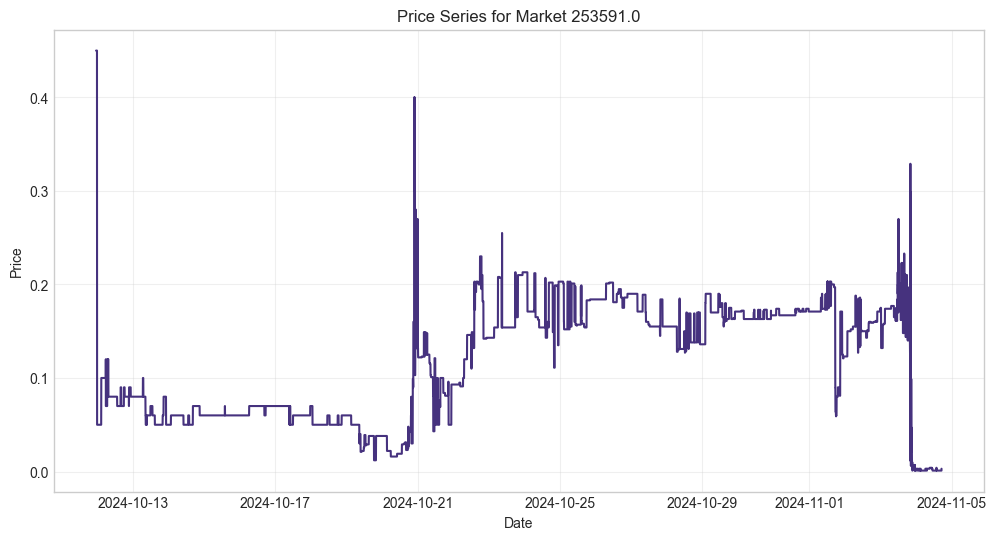

Exception ignored in: <function tqdm.__del__ at 0x147192f20>
Traceback (most recent call last):
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


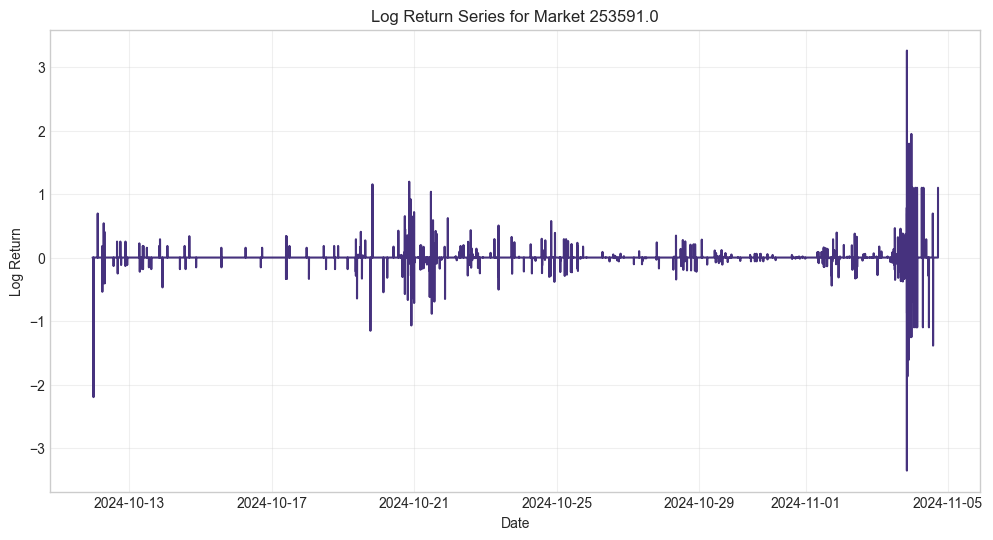

In [95]:
# Test the preprocessing function on one market
test_market_id = analysis_markets[0]
market_name = market_questions.get(str(test_market_id), f"Market {test_market_id}")
print(f"\nTesting preprocessing on market: {market_name} (ID: {test_market_id})")

market_data = preprocess_market_data(test_market_id)

if market_data is not None:
    print(f"Successfully processed market data with {len(market_data)} rows")
    display(market_data.head())
    
    # Plot price series
    plt.figure(figsize=(12, 6))
    plt.plot(market_data.index, market_data['price'])
    plt.title(f'Price Series for Market {test_market_id}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot return series
    plt.figure(figsize=(12, 6))
    plt.plot(market_data.index, market_data['log_return'])
    plt.title(f'Log Return Series for Market {test_market_id}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Failed to process market data. Let's try another market.")
    if len(analysis_markets) > 1:
        test_market_id = analysis_markets[1]
        market_name = market_questions.get(str(test_market_id), f"Market {test_market_id}")
        print(f"Trying market: {market_name} (ID: {test_market_id})")
        market_data = preprocess_market_data(test_market_id)
        if market_data is not None:
            print(f"Successfully processed market data with {len(market_data)} rows")
            display(market_data.head())



### 4.3 Define Efficiency Tests

In [96]:
def run_adf_test(series, series_type='price'):
    """
    Run Augmented Dickey-Fuller test for unit root.
    
    Parameters:
    -----------
    series : pd.Series
        Time series to test
    series_type : str
        Type of series ('price' or 'return')
        
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Run ADF test
    result = adfuller(series.dropna())
    
    # Format results
    adf_result = {
        'adf_statistic': result[0],
        'pvalue': result[1],
        'critical_values': result[4],
        'is_stationary': result[1] < 0.05  # Reject unit root if p-value < 0.05
    }
    
    return adf_result

def run_autocorrelation_tests(returns, lags=10):
    """
    Run ACF tests on return series.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    lags : int
        Number of lags to test
        
    Returns:
    --------
    dict
        Dictionary with ACF results and significance
    """
    # Calculate ACF
    acf_values = acf(returns, nlags=lags, fft=True)
    
    # Calculate significance threshold
    significance_level = 1.96 / np.sqrt(len(returns))  # 95% confidence level
    
    # Check for significant autocorrelation
    significant_lags = []
    for i in range(1, len(acf_values)):  # Skip lag 0 (always 1)
        if abs(acf_values[i]) > significance_level:
            significant_lags.append(i)
    
    result = {
        'acf_values': acf_values.tolist(),
        'significant_lags': significant_lags,
        'has_significant_autocorrelation': len(significant_lags) > 0
    }
    
    return result

def run_variance_ratio_test(returns, periods=[1, 5, 15, 60]):
    """
    Run variance ratio test to check if variance scales linearly with time.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    periods : list
        List of periods to test
        
    Returns:
    --------
    dict
        Dictionary with variance ratio results
    """
    results = {}
    
    # Calculate variance for base period
    base_period = periods[0]
    base_var = returns.var()
    
    for period in periods[1:]:
        # Skip if we don't have enough data
        if len(returns) < period * 10:
            continue
            
        # Aggregate returns for longer period
        agg_returns = returns.rolling(window=period).sum()
        agg_returns = agg_returns.dropna()
        
        if len(agg_returns) <= 1:
            continue
            
        # Calculate variance
        period_var = agg_returns.var()
        
        # Calculate variance ratio
        var_ratio = period_var / (period * base_var)
        
        # Random walk hypothesis: var_ratio should be close to 1
        # Calculate z-statistic (simplified)
        n = len(returns)
        std_error = np.sqrt(2 * (2 * period - 1) * (period - 1) / (3 * period * n))
        z_stat = (var_ratio - 1) / std_error
        p_value = 2 * (1 - abs(np.exp(-0.5 * z_stat**2) / np.sqrt(2 * np.pi)))
        
        results[f"{period}min"] = {
            'variance_ratio': var_ratio,
            'z_statistic': z_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'interpretation': 'Mean Reversion' if var_ratio < 1 else 'Momentum' if var_ratio > 1 else 'Random Walk'
        }
    
    return results

def run_runs_test(returns):
    """
    Run a runs test to check for non-random patterns in returns.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
        
    Returns:
    --------
    dict
        Dictionary with runs test results
    """
    # Convert returns to binary sequence (1 for positive, 0 for negative)
    binary_seq = (returns > 0).astype(int)
    
    # Count runs
    runs = 1
    for i in range(1, len(binary_seq)):
        if binary_seq.iloc[i] != binary_seq.iloc[i-1]:  # Use iloc for positional indexing
            runs += 1
    
    # Calculate expected runs and variance
    n = len(binary_seq)
    n1 = binary_seq.sum()  # Count of 1s
    n0 = n - n1  # Count of 0s
    
    if n0 == 0 or n1 == 0:  # All returns are positive or negative
        return {
            'runs': runs,
            'expected_runs': np.nan,
            'z_statistic': np.nan,
            'p_value': np.nan,
            'is_random': False
        }
    
    expected_runs = 1 + 2 * n1 * n0 / n
    std_runs = np.sqrt(2 * n1 * n0 * (2 * n1 * n0 - n) / (n**2 * (n-1)))
    
    # Calculate z-statistic
    z_stat = (runs - expected_runs) / std_runs
    p_value = 2 * (1 - abs(np.exp(-0.5 * z_stat**2) / np.sqrt(2 * np.pi)))
    
    return {
        'runs': runs,
        'expected_runs': expected_runs,
        'z_statistic': z_stat,
        'p_value': p_value,
        'is_random': p_value >= 0.05  # Null hypothesis is randomness
    }

def fit_ar_model(returns, lags=1):
    """
    Fit AR model to return series and evaluate predictability.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    lags : int
        Order of the AR model
        
    Returns:
    --------
    dict
        Dictionary with model results
    """
    if len(returns) <= lags + 2:
        return None
        
    # Fit AR model
    try:
        model = AutoReg(returns, lags=lags)
        model_fit = model.fit()
        
        # Extract coefficient and p-value
        coef = model_fit.params[1] if len(model_fit.params) > 1 else 0
        p_value = model_fit.pvalues[1] if len(model_fit.pvalues) > 1 else 1
        
        return {
            'ar_coefficient': coef,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }
    except Exception as e:
        print(f"Error fitting AR model: {e}")
        return None

def analyze_time_varying_efficiency(returns):
    """
    Analyze how efficiency changes over time by dividing the returns series 
    into early, middle, and late periods.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
        
    Returns:
    --------
    dict
        Dictionary with time-varying efficiency results
    """
    if len(returns) < 90:  # Need enough data to divide
        return None
    
    # Divide into three periods
    period_size = len(returns) // 3
    early_returns = returns.iloc[:period_size]
    mid_returns = returns.iloc[period_size:2*period_size]
    late_returns = returns.iloc[2*period_size:]
    
    # Test each period
    periods = {
        'early': early_returns,
        'middle': mid_returns,
        'late': late_returns
    }
    
    results = {}
    
    for period_name, period_returns in periods.items():
        if len(period_returns) < 30:  # Skip if not enough data
            continue
        
        # Calculate autocorrelation
        acf_result = run_autocorrelation_tests(period_returns)
        
        # Fit AR model
        ar_result = fit_ar_model(period_returns)
        
        results[period_name] = {
            'significant_acf': acf_result.get('has_significant_autocorrelation', False),
            'ar_model': ar_result,
            'return_volatility': period_returns.std(),
            'sample_size': len(period_returns)
        }
    
    # Compare early vs late
    if 'early' in results and 'late' in results:
        early_ar_sig = results['early'].get('ar_model', {}).get('significant', False) if results['early'].get('ar_model') else False
        late_ar_sig = results['late'].get('ar_model', {}).get('significant', False) if results['late'].get('ar_model') else False
        
        efficiency_change = 'No Change'
        if early_ar_sig and not late_ar_sig:
            efficiency_change = 'More Efficient'
        elif not early_ar_sig and late_ar_sig:
            efficiency_change = 'Less Efficient'
        
        volatility_ratio = results['late']['return_volatility'] / results['early']['return_volatility'] if results['early']['return_volatility'] > 0 else 1
        
        results['comparison'] = {
            'efficiency_change': efficiency_change,
            'volatility_ratio': volatility_ratio,
            'early_more_inefficient': early_ar_sig and not late_ar_sig,
            'late_more_inefficient': not early_ar_sig and late_ar_sig
        }
    
    return results

def analyze_cross_market_predictability(market_ids, max_lag=3):
    """Test for Granger causality between related markets"""
    if len(market_ids) < 2:
        return None
    
    # Process each market
    market_data = {}
    for market_id in market_ids:
        data = preprocess_market_data(market_id, resample='5min')  # Use wider intervals for cross-market
        if data is not None and len(data) > max_lag + 5:
            market_name = market_questions.get(str(market_id), f"Market {market_id}")
            market_data[market_id] = {
                'data': data,
                'name': market_name
            }
    
    if len(market_data) < 2:
        return None
    
    # Pairwise Granger causality tests
    causality_results = []
    
    for i, (market_i, data_i) in enumerate(market_data.items()):
        for j, (market_j, data_j) in enumerate(market_data.items()):
            if i >= j:  # Skip self-comparisons and duplicates
                continue
            
            # Align time series
            common_index = data_i['data'].index.intersection(data_j['data'].index)
            if len(common_index) <= max_lag + 5:
                continue
                
            series_i = data_i['data'].loc[common_index, 'price']
            series_j = data_j['data'].loc[common_index, 'price']
            
            # Test if market i Granger-causes market j
            try:
                # i -> j
                gc_result_ij = grangercausalitytests(
                    pd.concat([series_j, series_i], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ij = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ij.items()])
                
                # j -> i
                gc_result_ji = grangercausalitytests(
                    pd.concat([series_i, series_j], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ji = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ji.items()])
                
                causality_results.append({
                    'market_i_id': market_i,
                    'market_j_id': market_j,
                    'market_i_name': data_i['name'],
                    'market_j_name': data_j['name'],
                    'i_causes_j_pvalue': min_pvalue_ij,
                    'j_causes_i_pvalue': min_pvalue_ji,
                    'i_causes_j': min_pvalue_ij < 0.05,
                    'j_causes_i': min_pvalue_ji < 0.05,
                    'bidirectional': min_pvalue_ij < 0.05 and min_pvalue_ji < 0.05
                })
            except Exception as e:
                print(f"Error in Granger causality test: {e}")
    
    return causality_results

### 4.4 Run Tests on Single Market


Running efficiency tests on market: Market 253591.0

ADF test on price series:
ADF Statistic: -3.6383
p-value: 0.0051
Is stationary: True
Interpretation: Inefficient (not a random walk)

ADF test on return series:
ADF Statistic: -32.2634
p-value: 0.0000
Is stationary: True
Interpretation: Efficient

Autocorrelation test:
Significant lags: [1, 3, 5, 7, 9, 10]
Has significant autocorrelation: True
Interpretation: Inefficient

Variance ratio test:
  5min: Ratio = 0.6847, p-value = 2.0000, Interpretation: Mean Reversion
  15min: Ratio = 0.5541, p-value = 2.0000, Interpretation: Mean Reversion
  60min: Ratio = 0.3849, p-value = 2.0000, Interpretation: Mean Reversion

Runs test:
Runs: 666, Expected: 686.00
Z-statistic: -5.4043, p-value: 2.0000
Is random: True
Interpretation: Efficient

AR(1) model:
Coefficient: -0.1829
p-value: 0.0000
Significant: True
Interpretation: Inefficient

Time-varying efficiency:
  Early: Significant autocorrelation = True
    AR coefficient = -0.0237, significant 

<Figure size 1000x600 with 0 Axes>

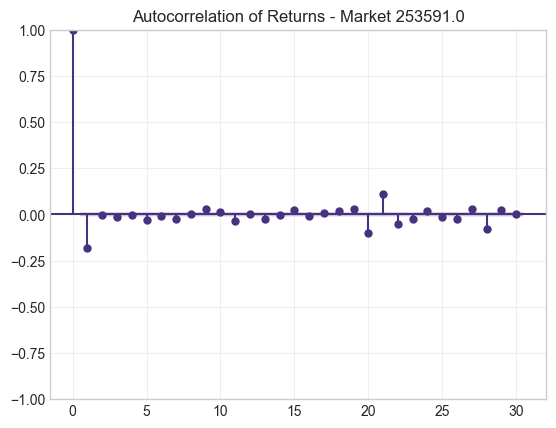

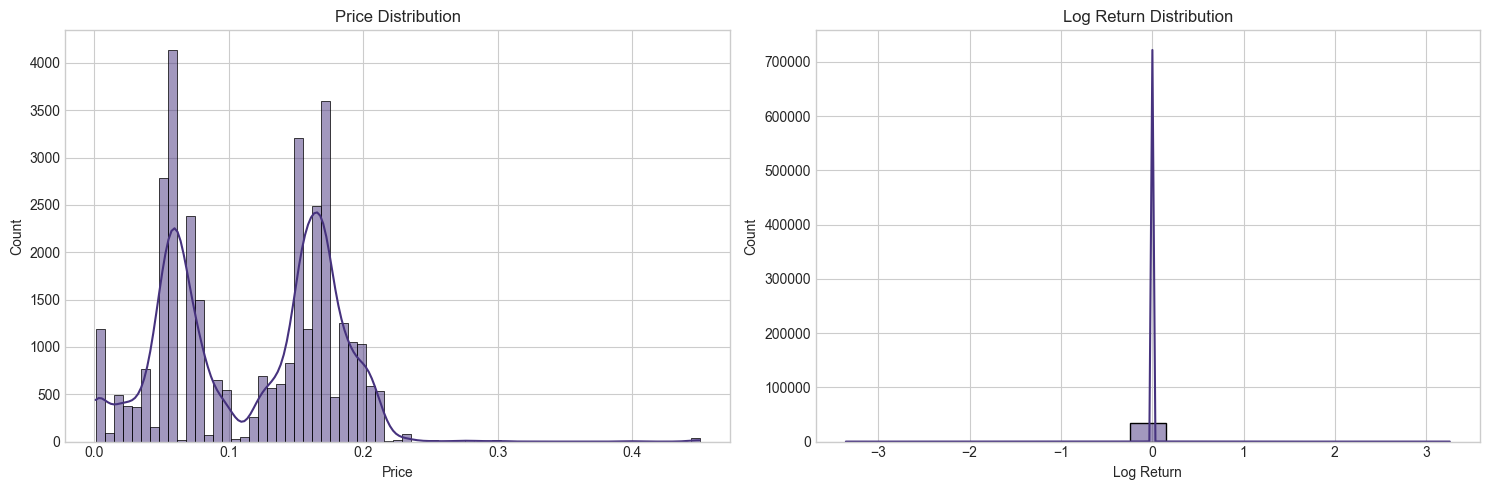

In [97]:
# Run efficiency tests on the test market
if market_data is not None and len(market_data) > 60:
    print("\nRunning efficiency tests on market:", market_name)
    
    # ADF test on price
    adf_price = run_adf_test(market_data['price'], 'price')
    print("\nADF test on price series:")
    print(f"ADF Statistic: {adf_price['adf_statistic']:.4f}")
    print(f"p-value: {adf_price['pvalue']:.4f}")
    print(f"Is stationary: {adf_price['is_stationary']}")
    print(f"Interpretation: {'Inefficient (not a random walk)' if adf_price['is_stationary'] else 'Efficient (random walk)'}")
    
    # ADF test on returns
    adf_return = run_adf_test(market_data['log_return'], 'return')
    print("\nADF test on return series:")
    print(f"ADF Statistic: {adf_return['adf_statistic']:.4f}")
    print(f"p-value: {adf_return['pvalue']:.4f}")
    print(f"Is stationary: {adf_return['is_stationary']}")
    print(f"Interpretation: {'Efficient' if adf_return['is_stationary'] else 'Inefficient'}")
    
    # Autocorrelation test
    acf_result = run_autocorrelation_tests(market_data['log_return'])
    print("\nAutocorrelation test:")
    print(f"Significant lags: {acf_result['significant_lags']}")
    print(f"Has significant autocorrelation: {acf_result['has_significant_autocorrelation']}")
    print(f"Interpretation: {'Inefficient' if acf_result['has_significant_autocorrelation'] else 'Efficient'}")
    
    # Variance ratio test
    vr_result = run_variance_ratio_test(market_data['log_return'])
    print("\nVariance ratio test:")
    for period, result in vr_result.items():
        print(f"  {period}: Ratio = {result['variance_ratio']:.4f}, p-value = {result['p_value']:.4f}, Interpretation: {result['interpretation']}")
    
    # Runs test
    runs_result = run_runs_test(market_data['log_return'])
    print("\nRuns test:")
    print(f"Runs: {runs_result['runs']:.0f}, Expected: {runs_result['expected_runs']:.2f}")
    print(f"Z-statistic: {runs_result['z_statistic']:.4f}, p-value: {runs_result['p_value']:.4f}")
    print(f"Is random: {runs_result['is_random']}")
    print(f"Interpretation: {'Efficient' if runs_result['is_random'] else 'Inefficient'}")
    
    # AR model
    ar_result = fit_ar_model(market_data['log_return'])
    if ar_result:
        print("\nAR(1) model:")
        print(f"Coefficient: {ar_result['ar_coefficient']:.4f}")
        print(f"p-value: {ar_result['p_value']:.4f}")
        print(f"Significant: {ar_result['significant']}")
        print(f"Interpretation: {'Inefficient' if ar_result['significant'] else 'Efficient'}")
    
    # Time-varying efficiency
    tv_result = analyze_time_varying_efficiency(market_data['log_return'])
    if tv_result:
        print("\nTime-varying efficiency:")
        for period_name, period_data in tv_result.items():
            if period_name != 'comparison':
                print(f"  {period_name.capitalize()}: Significant autocorrelation = {period_data.get('significant_acf', False)}")
                if 'ar_model' in period_data and period_data['ar_model']:
                    print(f"    AR coefficient = {period_data['ar_model']['ar_coefficient']:.4f}, significant = {period_data['ar_model']['significant']}")
        
        if 'comparison' in tv_result:
            print(f"  Efficiency change: {tv_result['comparison']['efficiency_change']}")
            print(f"  Volatility ratio (late/early): {tv_result['comparison']['volatility_ratio']:.2f}")
    
    # Create plots
    # ACF plot
    plt.figure(figsize=(10, 6))
    plot_acf(market_data['log_return'], lags=30, alpha=0.05)
    plt.title(f'Autocorrelation of Returns - {market_name}')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Price and returns histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(market_data['price'], kde=True, ax=ax1)
    ax1.set_title('Price Distribution')
    ax1.set_xlabel('Price')
    
    sns.histplot(market_data['log_return'], kde=True, ax=ax2)
    ax2.set_title('Log Return Distribution')
    ax2.set_xlabel('Log Return')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to run efficiency tests")

## 5. Comprehensive Efficiency Analysis of All Markets

### 5.1 Analysis Framework

In [98]:
def analyze_market_efficiency(market_id):
    """
    Run a comprehensive market efficiency analysis on a single market.
    
    Parameters:
    -----------
    market_id : str
        ID of the market to analyze
        
    Returns:
    --------
    dict
        Dictionary with efficiency results
    """
    market_result = {'market_id': market_id}
    market_name = market_questions.get(str(market_id), f"Market {market_id}")
    market_result['market_name'] = market_name
    
    # Preprocess market data using cached version
    market_data = preprocess_market_data_cached(market_id)
    if market_data is None or len(market_data) < 30:
        return None
    
    # Get market metadata
    market_rows = main_df[main_df[id_column] == market_id]
    if len(market_rows) == 0:
        # Try string comparison
        market_rows = main_df[main_df[id_column].astype(str) == str(market_id)]
    
    if len(market_rows) > 0:
        row = market_rows.iloc[0]
        
        # Extract market information safely
        if 'event_electionType' in row:
            market_result['event_type'] = row['event_electionType']
        if 'event_country' in row:
            market_result['country'] = row['event_country']
        if 'volumeNum' in row:
            market_result['volume'] = row['volumeNum']
        if 'market_duration_days' in row:
            market_result['duration_days'] = row['market_duration_days']
    
    # Run ADF tests
    market_result['adf_price'] = run_adf_test(market_data['price'], 'price')
    market_result['adf_return'] = run_adf_test(market_data['log_return'], 'return')
    
    # Run autocorrelation tests
    market_result['autocorrelation'] = run_autocorrelation_tests(market_data['log_return'])
    
    # Run variance ratio test
    market_result['variance_ratio'] = run_variance_ratio_test(market_data['log_return'])
    
    # Run runs test
    market_result['runs_test'] = run_runs_test(market_data['log_return'])
    
    # Fit AR model
    market_result['ar_model'] = fit_ar_model(market_data['log_return'])
    
    # Run time-varying efficiency analysis
    market_result['time_varying'] = analyze_time_varying_efficiency(market_data['log_return'])
    
    # Calculate overall efficiency score (0-100, higher = more efficient)
    score = 0
    max_points = 0
    
    # 1. Non-stationary price (random walk) = efficient
    if 'adf_price' in market_result:
        max_points += 1
        if not market_result['adf_price']['is_stationary']:
            score += 1
    
    # 2. Stationary returns = efficient
    if 'adf_return' in market_result:
        max_points += 1
        if market_result['adf_return']['is_stationary']:
            score += 1
    
    # 3. No significant autocorrelation = efficient
    if 'autocorrelation' in market_result:
        max_points += 1
        if not market_result['autocorrelation']['has_significant_autocorrelation']:
            score += 1
    
    # 4. Random runs test = efficient
    if 'runs_test' in market_result:
        max_points += 1
        if market_result['runs_test']['is_random']:
            score += 1
    
    # 5. No significant AR model = efficient
    if 'ar_model' in market_result and market_result['ar_model']:
        max_points += 1
        if not market_result['ar_model']['significant']:
            score += 1
    
    # 6. Variance ratio close to 1 = efficient
    if 'variance_ratio' in market_result and market_result['variance_ratio']:
        vr_count = 0
        for period, result in market_result['variance_ratio'].items():
            max_points += 0.5
            vr_count += 0.5
            if not result['significant']:  # Not significantly different from 1
                score += 0.5
    
    # Calculate percentage
    if max_points > 0:
        efficiency_score = (score / max_points) * 100
    else:
        efficiency_score = 0
    
    market_result['efficiency_score'] = efficiency_score
    
    # Efficiency classification
    if efficiency_score >= 80:
        market_result['efficiency_class'] = 'Highly Efficient'
    elif efficiency_score >= 60:
        market_result['efficiency_class'] = 'Moderately Efficient'
    elif efficiency_score >= 40:
        market_result['efficiency_class'] = 'Slightly Inefficient'
    else:
        market_result['efficiency_class'] = 'Highly Inefficient'
    
    return market_result


### 5.2 Run Analysis on All Selected Markets

In [99]:
def analyze_markets_efficiently(market_ids, n_jobs=4):
    """
    Run market efficiency analysis in parallel with caching
    
    Parameters:
    -----------
    market_ids : list
        List of market IDs to analyze
    n_jobs : int
        Number of parallel jobs (use -1 for all cores, or a specific number)
        
    Returns:
    --------
    list
        List of analysis results
    """
    print(f"Running analysis on {len(market_ids)} markets using {n_jobs} parallel workers...")
    start_time = time.time()
    
    # Run in parallel
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(analyze_market_efficiency)(market_id) for market_id in market_ids
    )
    
    # Filter out None results
    valid_results = [r for r in results if r is not None]
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"Successfully analyzed {len(valid_results)} markets in {execution_time:.2f} seconds")
    
    return valid_results

# Specify number of parallel jobs to use
# Use fewer cores if memory is limited
n_jobs = 4  # Adjust based on your machine's capabilities

# Run parallel analysis
print(f"Running comprehensive efficiency analysis on {len(analysis_markets)} markets...")
efficiency_results = analyze_markets_efficiently(analysis_markets, n_jobs=n_jobs)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(efficiency_results)

Running comprehensive efficiency analysis on 50 markets...
Running analysis on 50 markets using 4 parallel workers...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


No token IDs found for market 253591.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet
No token IDs found for market 253597.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253642.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253727.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253609.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253595.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253706.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253641.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253593.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253610.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253592.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253731.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253697.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253701.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253594.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253724.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253703.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253596.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253728.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet
No token IDs found for market 253698.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253730.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: divide by zero encountered in matmul
  return self._y.squeeze() - (self._x @ params).squeeze()
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: overflow encountered in matmul
  return self._y.squeeze

No token IDs found for market 253736.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253702.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253737.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253699.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet
No token IDs found for market 514165.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253843.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 500640.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253874.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253635.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253723.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet
No token IDs found for market 515761.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253598.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 506126.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 253836.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 514164.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 514163.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: divide by zero encountered in matmul
  return self._y.squeeze() - (self._x @ params).squeeze()
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: overflow encountered in matmul
  return self._y.squeeze

No token IDs found for market 501589.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 514162.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 501588.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 501590.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: divide by zero encountered in matmul
  return self._y.squeeze() - (self._x @ params).squeeze()
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: overflow encountered in matmul
  return self._y.squeeze

No token IDs found for market 253842.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 514027.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 501587.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 506125.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 501585.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: divide by zero encountered in matmul
  return self._y.squeeze() - (self._x @ params).squeeze()
/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:498: RuntimeWarning: overflow encountered in matmul
  return self._y.squeeze

No token IDs found for market 253639.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 253634.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

No token IDs found for market 500120.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


No token IDs found for market 255151.0
Returning sample file for testing: 23874437153982785160552190848753406234716605383255209659534817782884226760426.parquet 18-30-00-975.parquet


/Users/helenwu/Desktop/ML/polymarket_analysis/src/utils/data_loader.py:123: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/nd/jhhsrxqd28zg4zyvzl27_wfw0000gn/T/ipykernel_29388/707444562.py:201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

Successfully analyzed 50 markets in 117.62 seconds


### 5.3 Results Summary

In [100]:
# Display summary of results
print("\nEfficiency Analysis Summary:")
print(f"Total markets analyzed: {len(efficiency_results)}")

# Create DataFrame if it doesn't exist yet
if 'results_df' not in locals() or not isinstance(results_df, pd.DataFrame):
    results_df = pd.DataFrame(efficiency_results)

if len(results_df) > 0:
    # Overall statistics
    print(f"\nAverage efficiency score: {results_df['efficiency_score'].mean():.2f}/100")
    
    # Efficiency classification counts
    print("\nEfficiency Classification Breakdown:")
    class_counts = results_df['efficiency_class'].value_counts()
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} markets ({count/len(results_df)*100:.1f}%)")
    
    # Test results breakdown
    if 'adf_price' in results_df.columns:
        price_stationary = sum(results_df['adf_price'].apply(lambda x: x['is_stationary']))
        print(f"\nADF Test (Price): {price_stationary} markets ({price_stationary/len(results_df)*100:.1f}%) have stationary prices")
    
    if 'adf_return' in results_df.columns:
        return_stationary = sum(results_df['adf_return'].apply(lambda x: x['is_stationary']))
        print(f"ADF Test (Returns): {return_stationary} markets ({return_stationary/len(results_df)*100:.1f}%) have stationary returns")
    
    if 'autocorrelation' in results_df.columns:
        autocorrelation = sum(results_df['autocorrelation'].apply(lambda x: x['has_significant_autocorrelation']))
        print(f"Autocorrelation: {autocorrelation} markets ({autocorrelation/len(results_df)*100:.1f}%) have significant autocorrelation")
    
    if 'runs_test' in results_df.columns:
        random_runs = sum(results_df['runs_test'].apply(lambda x: x['is_random']))
        print(f"Runs Test: {random_runs} markets ({random_runs/len(results_df)*100:.1f}%) have random runs")
    
    if 'ar_model' in results_df.columns:
        ar_significant = sum(results_df['ar_model'].apply(lambda x: x.get('significant', False) if x else False))
        print(f"AR Model: {ar_significant} markets ({ar_significant/len(results_df)*100:.1f}%) have significant AR(1) coefficients")
else:
    print("No results to summarize. Make sure the analysis completed successfully.")


Efficiency Analysis Summary:
Total markets analyzed: 50

Average efficiency score: 53.85/100

Efficiency Classification Breakdown:
  Slightly Inefficient: 50 markets (100.0%)

ADF Test (Price): 50 markets (100.0%) have stationary prices
ADF Test (Returns): 50 markets (100.0%) have stationary returns
Autocorrelation: 50 markets (100.0%) have significant autocorrelation
Runs Test: 50 markets (100.0%) have random runs
AR Model: 50 markets (100.0%) have significant AR(1) coefficients


## 6. Data Visualization and Interpretation
### 6.1 Distribution of Efficiency Score

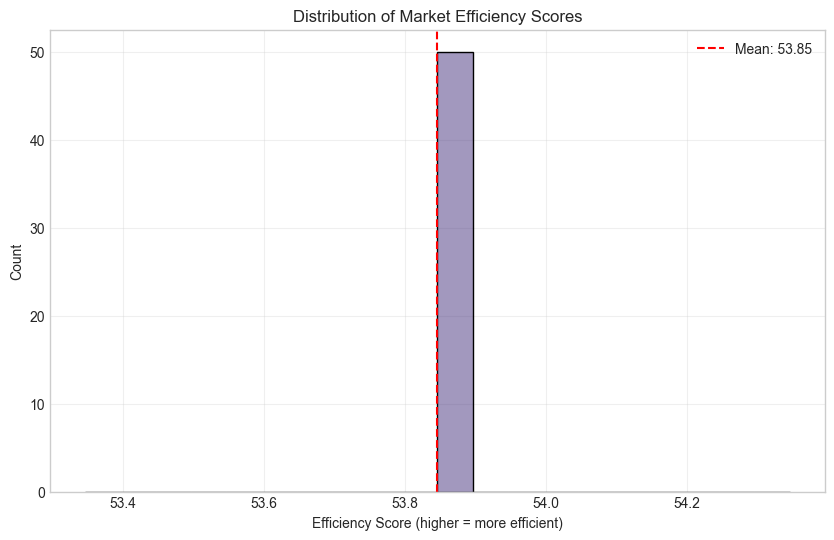

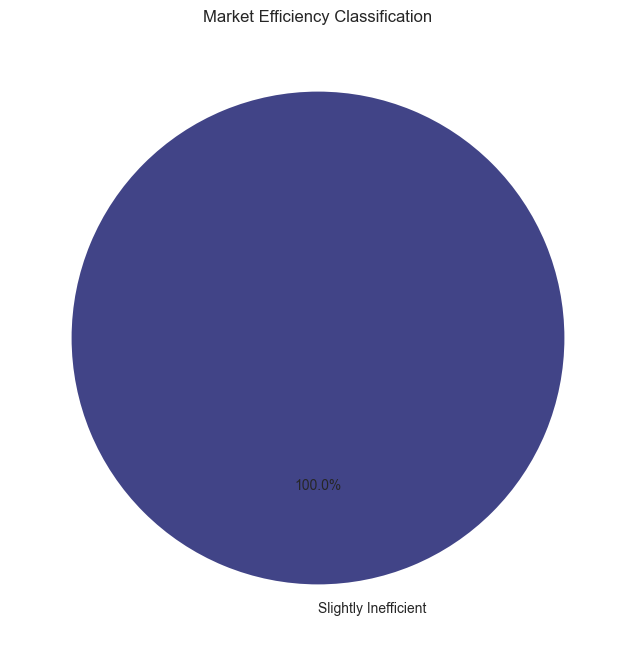

In [101]:
# Histogram of efficiency scores
plt.figure(figsize=(10, 6))
sns.histplot(results_df['efficiency_score'], bins=20, kde=True)
plt.axvline(x=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df["efficiency_score"].mean():.2f}')
plt.title('Distribution of Market Efficiency Scores')
plt.xlabel('Efficiency Score (higher = more efficient)')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Efficiency classification pie chart
plt.figure(figsize=(10, 8))
results_df['efficiency_class'].value_counts().plot.pie(autopct='%1.1f%%', 
                                                     colors=sns.color_palette("viridis", 4),
                                                     startangle=90)
plt.title('Market Efficiency Classification')
plt.ylabel('')  # Hide ylabel
plt.show()

### 6.2 Efficiency by Market Characteristics


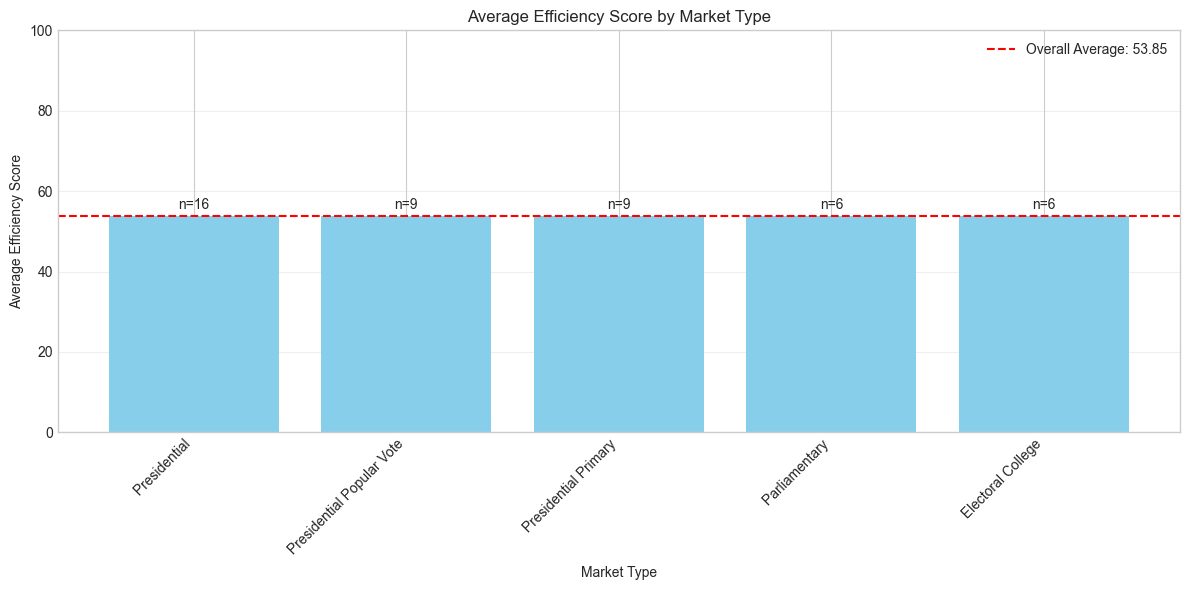

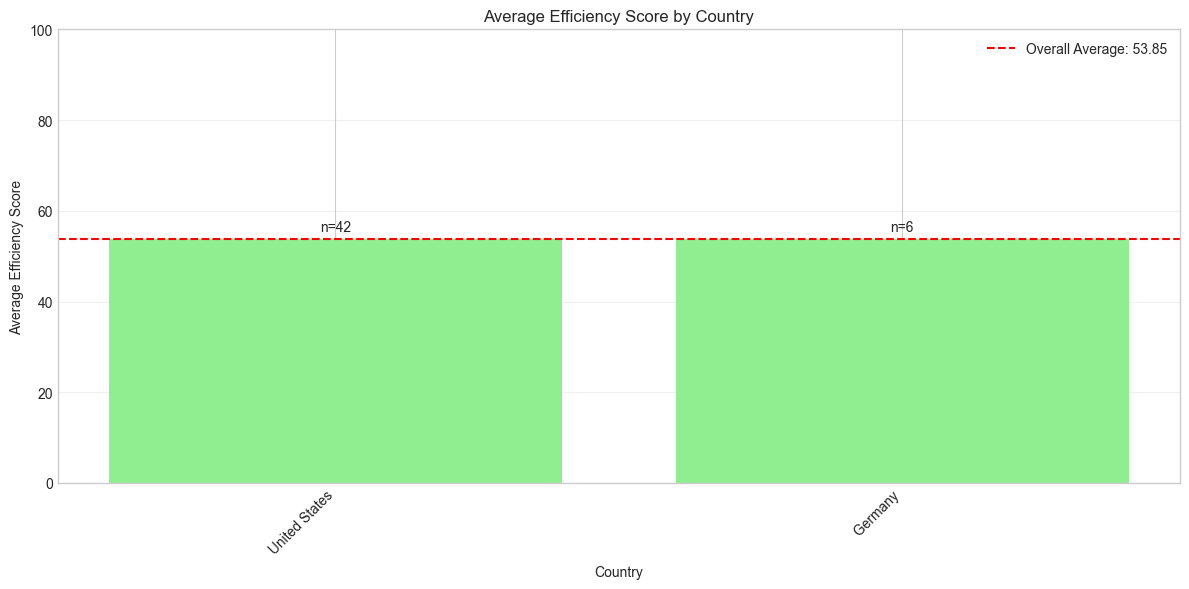

In [102]:
if 'event_type' in results_df.columns:
    # Filter to include only market types with sufficient data
    type_counts = results_df['event_type'].value_counts()
    market_types = type_counts[type_counts >= 5].index.tolist()
    
    if market_types:
        type_data = []
        for market_type in market_types:
            type_df = results_df[results_df['event_type'] == market_type]
            type_data.append({
                'Market Type': market_type,
                'Average Efficiency': type_df['efficiency_score'].mean(),
                'Count': len(type_df)
            })
        
        type_df = pd.DataFrame(type_data).sort_values('Average Efficiency', ascending=False)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(type_df['Market Type'], type_df['Average Efficiency'], color='skyblue')
        
        # Add count labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                    f"n={type_df['Count'].iloc[i]}", 
                    ha='center', va='bottom')
        
        plt.axhline(y=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
                   label=f'Overall Average: {results_df["efficiency_score"].mean():.2f}')
        
        plt.title('Average Efficiency Score by Market Type')
        plt.xlabel('Market Type')
        plt.ylabel('Average Efficiency Score')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# %%
# Efficiency by region/country
if 'country' in results_df.columns:
    # Filter to include only countries with sufficient data
    country_counts = results_df['country'].value_counts()
    countries = country_counts[country_counts >= 5].index.tolist()
    
    if countries:
        country_data = []
        for country in countries:
            country_df = results_df[results_df['country'] == country]
            country_data.append({
                'Country': country,
                'Average Efficiency': country_df['efficiency_score'].mean(),
                'Count': len(country_df)
            })
        
        country_df = pd.DataFrame(country_data).sort_values('Average Efficiency', ascending=False)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(country_df['Country'], country_df['Average Efficiency'], color='lightgreen')
        
        # Add count labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                    f"n={country_df['Count'].iloc[i]}", 
                    ha='center', va='bottom')
        
        plt.axhline(y=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
                   label=f'Overall Average: {results_df["efficiency_score"].mean():.2f}')
        
        plt.title('Average Efficiency Score by Country')
        plt.xlabel('Country')
        plt.ylabel('Average Efficiency Score')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

### 6.3 Efficiency vs Market Characteristics

Exception ignored in: <function tqdm.__del__ at 0x147192f20>
Traceback (most recent call last):
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x147192f20>
Traceback (most recent call last):
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/helenwu/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x147192f20>
Traceback (most recent call last):
  File "/Users/helenwu

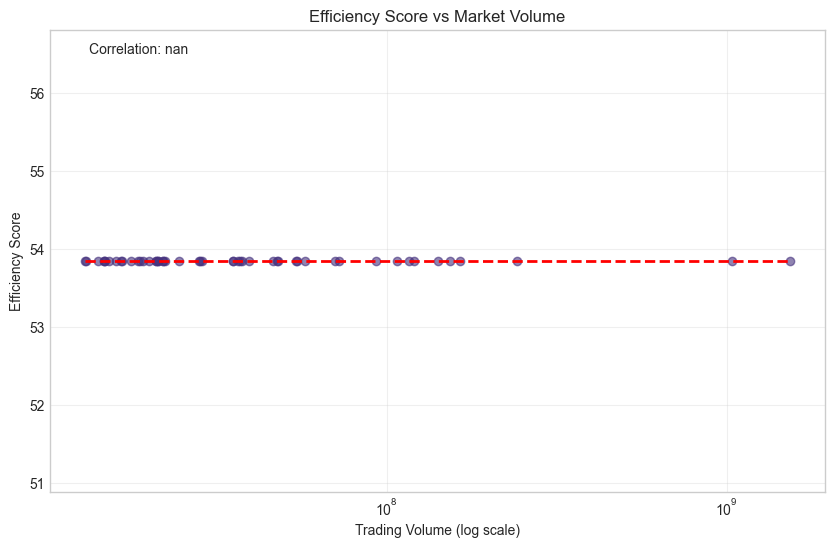

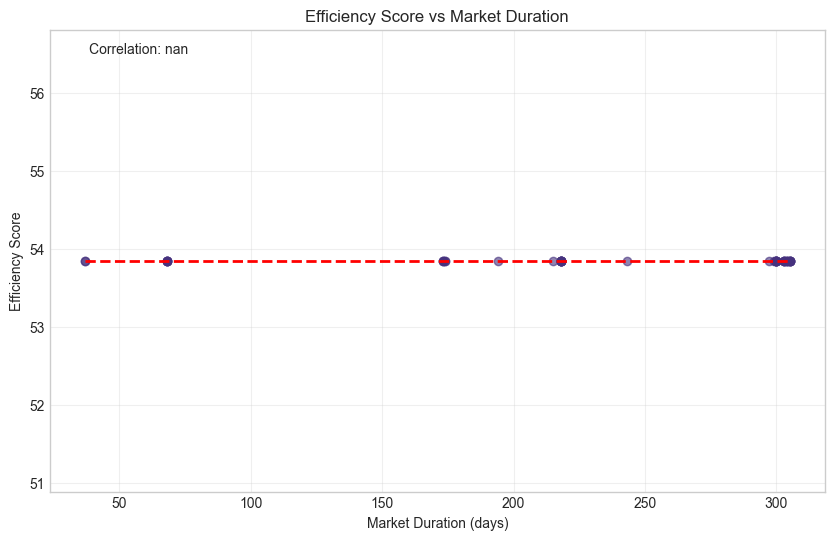

In [103]:
# Efficiency vs Market Volume
if 'volume' in results_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['volume'], results_df['efficiency_score'], alpha=0.6)
    plt.xscale('log')  # Use log scale for volume
    plt.title('Efficiency Score vs Market Volume')
    plt.xlabel('Trading Volume (log scale)')
    plt.ylabel('Efficiency Score')
    
    # Add trend line
    try:
        z = np.polyfit(np.log10(results_df['volume']), results_df['efficiency_score'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(results_df['volume']), 
                p(np.log10(sorted(results_df['volume']))), 
                "r--", linewidth=2)
        
        # Calculate correlation
        corr = np.corrcoef(np.log10(results_df['volume']), results_df['efficiency_score'])[0, 1]
        plt.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=plt.gca().transAxes)
    except:
        pass
    
    plt.grid(alpha=0.3)
    plt.show()

# %%
# Efficiency vs Market Duration
if 'duration_days' in results_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['duration_days'], results_df['efficiency_score'], alpha=0.6)
    plt.title('Efficiency Score vs Market Duration')
    plt.xlabel('Market Duration (days)')
    plt.ylabel('Efficiency Score')
    
    # Add trend line
    try:
        z = np.polyfit(results_df['duration_days'], results_df['efficiency_score'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(results_df['duration_days']), 
                p(sorted(results_df['duration_days'])), 
                "r--", linewidth=2)
        
        # Calculate correlation
        corr = np.corrcoef(results_df['duration_days'], results_df['efficiency_score'])[0, 1]
        plt.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=plt.gca().transAxes)
    except:
        pass
    
    plt.grid(alpha=0.3)
    plt.show()

### 6.4 Time-Varying Efficiency Analysis


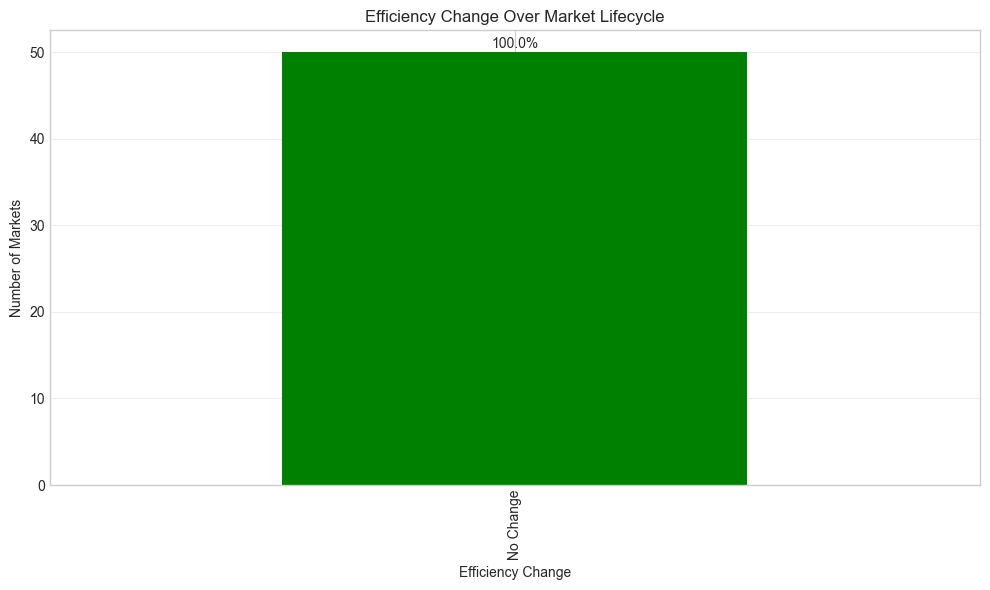

In [104]:
# Analyze time-varying efficiency results
tv_data = []

for result in efficiency_results:
    tv = result.get('time_varying', {})
    if tv and 'comparison' in tv:
        tv_data.append({
            'market_id': result['market_id'],
            'market_name': result.get('market_name', f"Market {result['market_id']}"),
            'efficiency_change': tv['comparison']['efficiency_change'],
            'early_more_inefficient': tv['comparison'].get('early_more_inefficient', False),
            'late_more_inefficient': tv['comparison'].get('late_more_inefficient', False),
            'volatility_ratio': tv['comparison'].get('volatility_ratio', 1)
        })

if tv_data:
    tv_df = pd.DataFrame(tv_data)
    
    # Count markets in each category
    efficiency_change_counts = tv_df['efficiency_change'].value_counts()
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = efficiency_change_counts.plot.bar(color=['green', 'gray', 'red'])
    
    plt.title('Efficiency Change Over Market Lifecycle')
    plt.xlabel('Efficiency Change')
    plt.ylabel('Number of Markets')
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(tv_df)
    for i, count in enumerate(efficiency_change_counts):
        plt.text(i, count + 0.5, f"{count/total*100:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()

## 7. Cross-Market Analysis (Market Relatedness)

In [105]:
def find_related_markets(event_id):
    """Find markets that are part of the same event"""
    # Determine the event column
    event_col = None
    for col in ['event_id', 'groupId', 'group_id', 'event']:
        if col in main_df.columns:
            event_col = col
            break
    
    if not event_col:
        print("Could not find an event identifier column")
        return []
    
    # Get markets in this event
    event_markets = main_df[main_df[event_col] == event_id]
    if len(event_markets) <= 1:
        return []
    
    return event_markets[id_column].unique().tolist()

def analyze_cross_market_predictability(market_ids, max_lag=3):
    """Test for Granger causality between related markets"""
    if len(market_ids) < 2:
        return None
    
    # Process each market (using cached version)
    market_data = {}
    for market_id in market_ids:
        data = preprocess_market_data_cached(market_id, resample='5min')  # Use wider intervals for cross-market
        if data is not None and len(data) > max_lag + 5:
            market_name = market_questions.get(str(market_id), f"Market {market_id}")
            market_data[market_id] = {
                'data': data,
                'name': market_name
            }
    
    if len(market_data) < 2:
        return None
    
    # Pairwise Granger causality tests
    causality_results = []
    
    for i, (market_i, data_i) in enumerate(market_data.items()):
        for j, (market_j, data_j) in enumerate(market_data.items()):
            if i >= j:  # Skip self-comparisons and duplicates
                continue
            
            # Align time series
            common_index = data_i['data'].index.intersection(data_j['data'].index)
            if len(common_index) <= max_lag + 5:
                continue
                
            series_i = data_i['data'].loc[common_index, 'price']
            series_j = data_j['data'].loc[common_index, 'price']
            
            # Test if market i Granger-causes market j
            try:
                # i -> j
                gc_result_ij = grangercausalitytests(
                    pd.concat([series_j, series_i], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ij = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ij.items()])
                
                # j -> i
                gc_result_ji = grangercausalitytests(
                    pd.concat([series_i, series_j], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ji = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ji.items()])
                
                causality_results.append({
                    'market_i_id': market_i,
                    'market_j_id': market_j,
                    'market_i_name': data_i['name'],
                    'market_j_name': data_j['name'],
                    'i_causes_j_pvalue': min_pvalue_ij,
                    'j_causes_i_pvalue': min_pvalue_ji,
                    'i_causes_j': min_pvalue_ij < 0.05,
                    'j_causes_i': min_pvalue_ji < 0.05,
                    'bidirectional': min_pvalue_ij < 0.05 and min_pvalue_ji < 0.05
                })
            except Exception as e:
                print(f"Error in Granger causality test: {e}")
    
    return causality_results# Market Efficiency Analysis for Prediction Markets
# ----------------------------------------------